# DBLP Topic Modeling & Trends Analysis

**Team Member:** Julio Amaya  
**Task:** NLP & Topic Modeling  
**Date:** December 4, 2025

## Overview

This notebook performs topic modeling on DBLP research abstracts to discover research themes and track their evolution:

1. Load and preprocess paper abstracts
2. Generate TF-IDF features
3. Train topic models (LDA and NMF)
4. Extract and label topics
5. Analyze topic evolution over time
6. Visualize topic distributions by venue and year
7. Track topic trends and novelty

---

## 1. Setup and Imports

In [2]:
# Import libraries
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import custom NLP modules
from src.nlp_modeling.text_processing import clean_text, generate_tfidf_features, reduce_dimensions
from src.nlp_modeling.models import (
    train_topic_model, 
    get_top_topics, 
    display_topics, 
    compute_coherence,
    get_document_topics
)

# Plotting settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Create output directories
FIGURES_DIR = Path("../figures")
MODELS_DIR = Path("../models")
FIGURES_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

print("✓ Libraries imported successfully")
print(f"Figures will be saved to: {FIGURES_DIR.absolute()}")
print(f"Models will be saved to: {MODELS_DIR.absolute()}")

✓ Libraries imported successfully
Figures will be saved to: /Users/julio/Library/CloudStorage/OneDrive-UniversityOfHouston/0. Fall 2025/COSC3337/GitProject/COSC-3337-Project/notebooks/../figures
Models will be saved to: /Users/julio/Library/CloudStorage/OneDrive-UniversityOfHouston/0. Fall 2025/COSC3337/GitProject/COSC-3337-Project/notebooks/../models


## 2. Load and Explore Data

In [3]:
# Load papers data
DATA_DIR = Path("../data/parquet")
papers = pd.read_parquet(DATA_DIR / 'papers')

print(f"Total papers: {len(papers):,}")
print(f"\nDataset info:")
print(papers.info())

# Check abstract availability
print(f"\nAbstracts available: {papers['abstract'].notna().sum():,} ({papers['abstract'].notna().sum()/len(papers)*100:.1f}%)")
print(f"Missing abstracts: {papers['abstract'].isna().sum():,}")

# Sample abstracts
print("\nSample abstracts:")
print(papers[papers['abstract'].notna()][['title', 'abstract', 'year']].head(3))

Total papers: 100,000

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            100000 non-null  object 
 1   title         100000 non-null  object 
 2   venue         100000 non-null  object 
 3   year          100000 non-null  int64  
 4   n_citation    100000 non-null  int64  
 5   abstract      39476 non-null   object 
 6   abstract_len  39476 non-null   float64
 7   ref_count     100000 non-null  int64  
 8   author_count  100000 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 6.9+ MB
None

Abstracts available: 39,476 (39.5%)
Missing abstracts: 60,524

Sample abstracts:
                                               title  \
0  Preliminary Design of a Network Protocol Learn...   
1  A methodology for the physically accurate visu...   
2  Comparison of GARCH, Neural Network and Suppor... 

## 3. Text Preprocessing

In [4]:
# Filter papers with abstracts and create text corpus
papers_with_text = papers[papers['abstract'].notna()].copy()

# Combine title and abstract for better topic modeling
papers_with_text['text'] = papers_with_text['title'].fillna('') + ' ' + papers_with_text['abstract'].fillna('')

print(f"Papers with text for analysis: {len(papers_with_text):,}")

# Clean text
print("Cleaning text...")
papers_with_text['text_clean'] = papers_with_text['text'].apply(clean_text)

# Remove empty texts after cleaning
papers_with_text = papers_with_text[papers_with_text['text_clean'].str.len() > 20].copy()

print(f"Papers after cleaning: {len(papers_with_text):,}")
print("\nSample cleaned text:")
print(papers_with_text[['title', 'text_clean']].head(2))

Papers with text for analysis: 39,476
Cleaning text...
Papers after cleaning: 39,476

Sample cleaned text:
                                               title  \
0  Preliminary Design of a Network Protocol Learn...   
1  A methodology for the physically accurate visu...   

                                          text_clean  
0  preliminary design of a network protocol learn...  
1  a methodology for the physically accurate visu...  
Papers after cleaning: 39,476

Sample cleaned text:
                                               title  \
0  Preliminary Design of a Network Protocol Learn...   
1  A methodology for the physically accurate visu...   

                                          text_clean  
0  preliminary design of a network protocol learn...  
1  a methodology for the physically accurate visu...  


## 4. Generate TF-IDF Features

In [5]:
# Generate TF-IDF features
print("Generating TF-IDF features...")
tfidf_matrix, vectorizer = generate_tfidf_features(papers_with_text['text_clean'])

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")
print(f"Sparsity: {(1.0 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100:.2f}%")

# Show top TF-IDF terms
feature_names = vectorizer.get_feature_names_out()
print(f"\nSample features (first 20): {feature_names[:20]}")

Generating TF-IDF features...
TF-IDF matrix shape: (39476, 10000)
Vocabulary size: 10000
Sparsity: 99.39%

Sample features (first 20): ['aal' 'ab' 'abc' 'abdominal' 'abduction' 'abductive' 'abe' 'abelian'
 'abilities' 'ability' 'able' 'able detect' 'able provide' 'abnormal'
 'absence' 'absent' 'absolute' 'abstract' 'abstract interpretation'
 'abstract paper']
TF-IDF matrix shape: (39476, 10000)
Vocabulary size: 10000
Sparsity: 99.39%

Sample features (first 20): ['aal' 'ab' 'abc' 'abdominal' 'abduction' 'abductive' 'abe' 'abelian'
 'abilities' 'ability' 'able' 'able detect' 'able provide' 'abnormal'
 'absence' 'absent' 'absolute' 'abstract' 'abstract interpretation'
 'abstract paper']


## 5. Train Topic Models

We'll train both LDA and NMF models and compare their performance.

In [6]:
# Train LDA model
print("Training LDA model...")
n_topics = 15
lda_model = train_topic_model(tfidf_matrix, n_topics=n_topics, algorithm='lda', random_state=42)

# Get topics
lda_topics = get_top_topics(lda_model, vectorizer, n_words=10)

print(f"\n{'='*80}")
print(f"LDA Topics (n={n_topics}):")
print('='*80)
display_topics(lda_topics, n_words=10)

# Compute coherence
lda_coherence = compute_coherence(lda_model, tfidf_matrix, vectorizer)
print(f"\nLDA Coherence Score: {lda_coherence:.4f}")

Training LDA model...

LDA Topics (n=15):
Topic 0: sentiment, page, emotion, copy, polarity, pubmed, lingual, print, cross lingual, pdf
Topic 1: image, images, segmentation, method, motion, detection, recognition, shape, color, object
Topic 2: fingerprint, abc, deontic, symmetries, facet, job shop, hellman, review, diffie hellman, diffie
Topic 3: speech, la, des, recognition, les, speaker, speech recognition, et, une, le
Topic 4: security, attacks, attack, secure, scheme, key, privacy, authentication, encryption, protocol
Topic 5: translation, word, language, words, english, chinese, corpus, lexical, machine translation, corpora
Topic 6: network, algorithm, performance, time, networks, based, problem, data, parallel, paper
Topic 7: xml, seminar, conference, dagstuhl, abstracts, international, dagstuhl seminar, international conference, th, xml data
Topic 8: logic, der, die, und, semantics, reasoning, programs, von, logics, proof
Topic 9: software, service, systems, services, management

In [7]:
# Train NMF model
print("Training NMF model...")
nmf_model = train_topic_model(tfidf_matrix, n_topics=n_topics, algorithm='nmf', random_state=42)

# Get topics
nmf_topics = get_top_topics(nmf_model, vectorizer, n_words=10)

print(f"\n{'='*80}")
print(f"NMF Topics (n={n_topics}):")
print('='*80)
display_topics(nmf_topics, n_words=10)

# Compute coherence
nmf_coherence = compute_coherence(nmf_model, tfidf_matrix, vectorizer)
print(f"\nNMF Coherence Score: {nmf_coherence:.4f}")

Training NMF model...

NMF Topics (n=15):
Topic 0: model, models, modeling, process, based, simulation, model based, approach, checking, state
Topic 1: software, systems, design, development, process, research, management, business, engineering, information
Topic 2: algorithm, problem, algorithms, problems, time, optimization, graph, search, number, optimal
Topic 3: data, mining, data mining, clustering, analysis, classification, sets, large, database, data sets
Topic 4: knowledge, logic, fuzzy, reasoning, language, semantics, rules, ontology, representation, domain
Topic 5: der, die, und, von, werden, eine, zu, mit, zur, ein
Topic 6: learning, students, student, machine, machine learning, training, learners, teaching, learner, education
Topic 7: web, information, semantic, search, retrieval, query, queries, semantic web, ontology, documents
Topic 8: la, des, les, et, une, le, en, pour, est, dans
Topic 9: network, networks, neural, sensor, wireless, nodes, energy, neural network, traff

## 6. Assign Topics to Documents

Assign each paper to its dominant topic for analysis.

In [8]:
# Use LDA model for final analysis (can switch to NMF if preferred)
selected_model = lda_model
selected_topics = lda_topics
model_name = "LDA"

# Get dominant topic for each document
papers_with_text['topic'] = get_document_topics(selected_model, tfidf_matrix, top_n=1)

# Create topic labels from top words
topic_labels = {i: ', '.join(words[:3]) for i, words in selected_topics.items()}
papers_with_text['topic_label'] = papers_with_text['topic'].map(topic_labels)

print(f"Topic distribution:")
print(papers_with_text['topic'].value_counts().sort_index())

print(f"\nSample papers with topics:")
print(papers_with_text[['title', 'year', 'topic', 'topic_label']].head(10))

Topic distribution:
topic
0        65
1      1064
2        12
3       271
4       263
5        12
6      7695
7        36
8       515
9      5198
10     8249
11     1385
12    12586
13       51
14     2074
Name: count, dtype: int64

Sample papers with topics:
                                                title  year  topic  \
0   Preliminary Design of a Network Protocol Learn...  2013     10   
1   A methodology for the physically accurate visu...  2011     10   
2   Comparison of GARCH, Neural Network and Suppor...  2009     12   
10  Identifying Psychological Theme Words from Emo...  2013     10   
12  Multisymplectic Spectral Methods for the Gross...  2002     11   
13  Relational Abstract Interpretation of Higher O...  1991     12   
14  Speech training systems using lateral shapes o...  1979     10   
16  Knowledge Engineering for Affective Bi-Modal I...  2008     10   
20              Link-time compaction of MIPS programs  2004      6   
22  Leveraging legacy code to deploy des

## 7. Visualize Topic Distribution

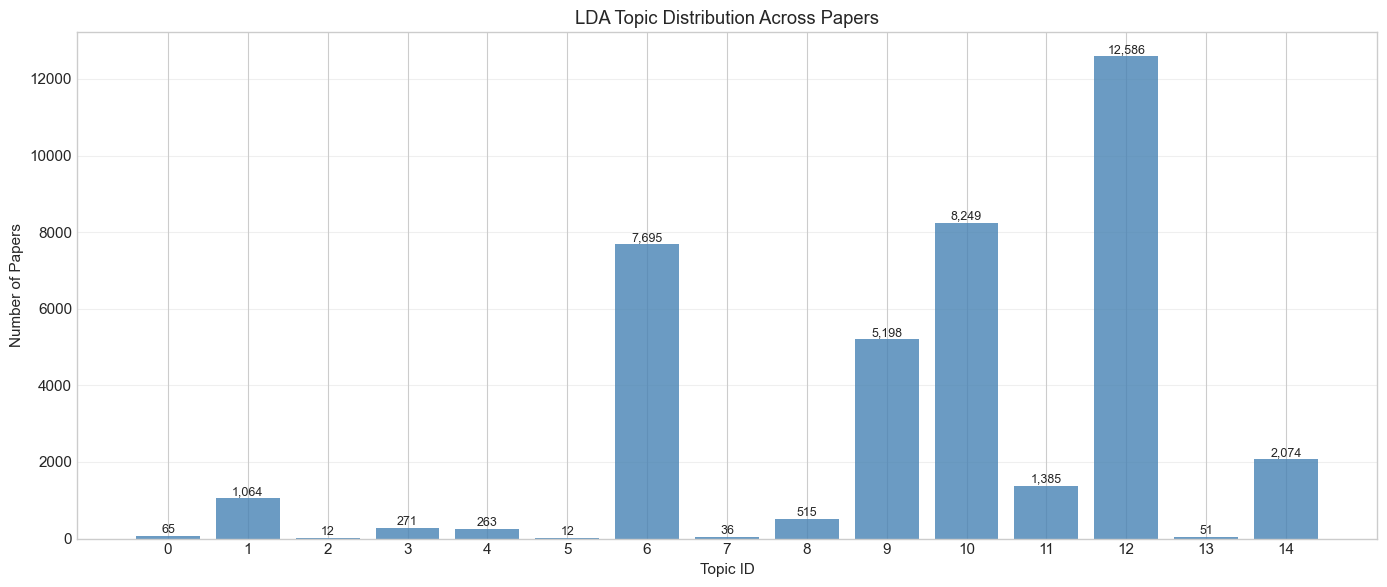

✓ Figure saved to ../figures


In [9]:
# Topic distribution bar chart
topic_counts = papers_with_text['topic'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(topic_counts.index, topic_counts.values, color='steelblue', alpha=0.8)
ax.set_xlabel('Topic ID')
ax.set_ylabel('Number of Papers')
ax.set_title(f'{model_name} Topic Distribution Across Papers')
ax.set_xticks(range(n_topics))
ax.grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig5_topic_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figure saved to {FIGURES_DIR}")

## 8. Topic Evolution Over Time

Analyze how topics have evolved and gained/lost popularity over the years.

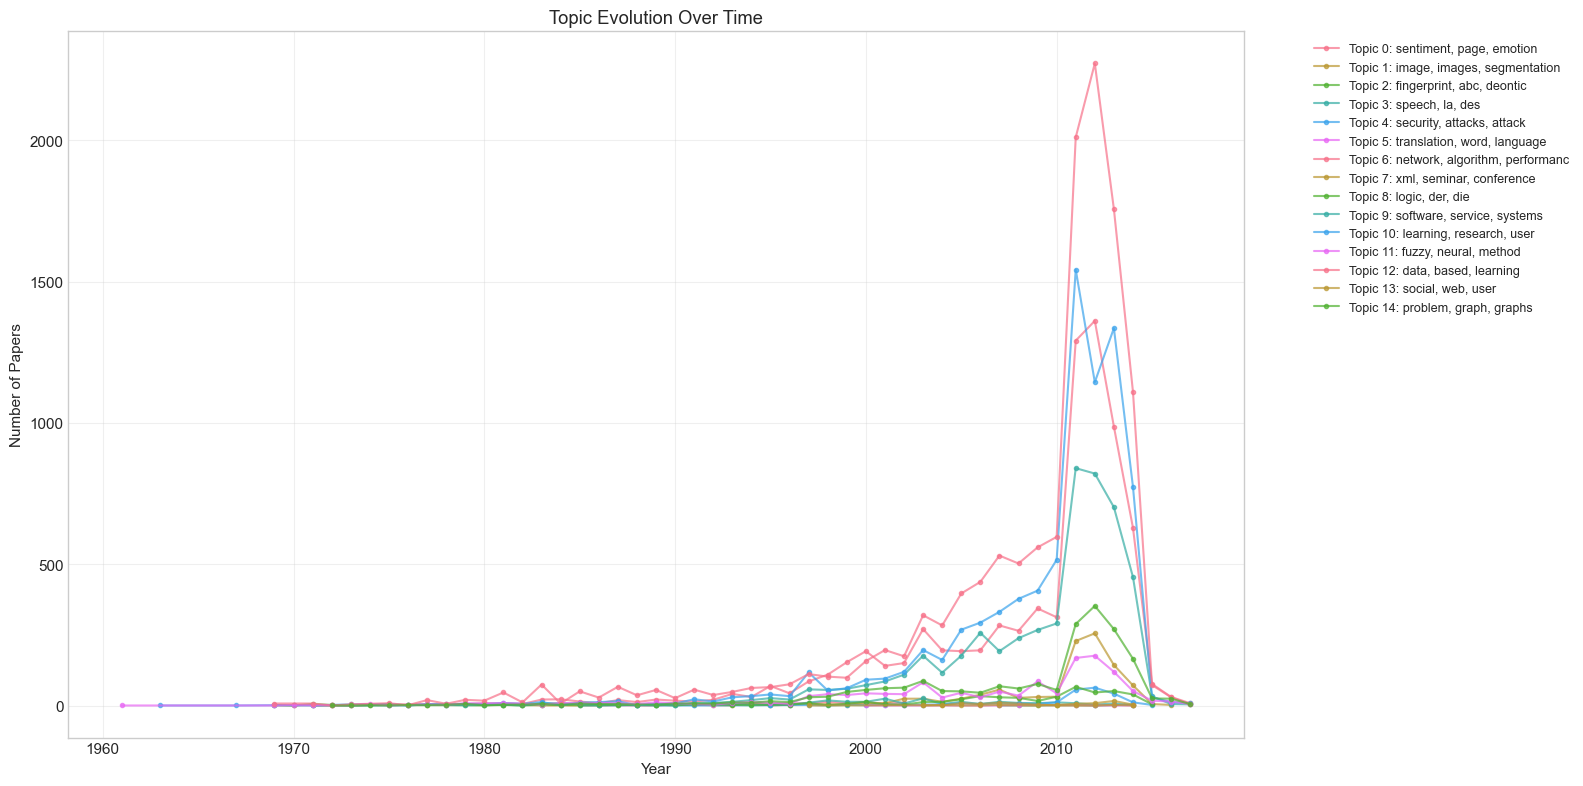

✓ Figure saved to ../figures


In [10]:
# Filter to papers with valid years
papers_temporal = papers_with_text[papers_with_text['year'].notna()].copy()

# Topic trends over time
topic_by_year = papers_temporal.groupby(['year', 'topic']).size().reset_index(name='count')

# Plot topic evolution
fig, ax = plt.subplots(figsize=(16, 8))

for topic_id in range(n_topics):
    topic_data = topic_by_year[topic_by_year['topic'] == topic_id]
    if len(topic_data) > 0:
        ax.plot(topic_data['year'], topic_data['count'], 
                label=f"Topic {topic_id}: {topic_labels[topic_id][:30]}", 
                marker='o', markersize=3, alpha=0.7)

ax.set_xlabel('Year')
ax.set_ylabel('Number of Papers')
ax.set_title('Topic Evolution Over Time')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig6_topic_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figure saved to {FIGURES_DIR}")

## 9. Summary and Export

Save models and topic assignments for future use.

In [11]:
# Save models
import joblib

joblib.dump(selected_model, MODELS_DIR / f'{model_name.lower()}_model.pkl')
joblib.dump(vectorizer, MODELS_DIR / 'tfidf_vectorizer.pkl')

print(f"✓ Models saved to {MODELS_DIR}")

# Save topic assignments
papers_with_text[['id', 'title', 'year', 'topic', 'topic_label']].to_csv(
    MODELS_DIR / 'paper_topics.csv', index=False
)

# Save topic descriptions
topic_descriptions = pd.DataFrame([
    {'topic_id': i, 'top_words': ', '.join(words), 'label': topic_labels[i]}
    for i, words in selected_topics.items()
])
topic_descriptions.to_csv(MODELS_DIR / 'topic_descriptions.csv', index=False)

print(f"✓ Topic data saved to {MODELS_DIR}")

# Summary
print("\n" + "="*80)
print("TOPIC MODELING SUMMARY")
print("="*80)
print(f"Model: {model_name}")
print(f"Number of topics: {n_topics}")
print(f"Papers analyzed: {len(papers_with_text):,}")
print(f"Coherence score: {lda_coherence:.4f}")
print(f"\nFiles generated:")
print(f"  - Models: {MODELS_DIR}")
print(f"  - Figures: {FIGURES_DIR}")
print("\nNext steps:")
print("  - Analyze topic-venue mappings")
print("  - Track specific topic trends (e.g., 'deep learning')")
print("  - Compute novelty scores")
print("="*80)

✓ Models saved to ../models
✓ Topic data saved to ../models

TOPIC MODELING SUMMARY
Model: LDA
Number of topics: 15
Papers analyzed: 39,476
Coherence score: -12289.4518

Files generated:
  - Models: ../models
  - Figures: ../figures

Next steps:
  - Analyze topic-venue mappings
  - Track specific topic trends (e.g., 'deep learning')
  - Compute novelty scores
